# *Portfolio Management with Machine Learning* 
## **Forecasting returns and managing possitions**

## 1. Introduction
With the development of machine learning and the increasing disponibility of free high frequency financial data online, the oportunities to implement this techniques to forecast the behaviour and manage assets arise. 

In this notebook I use machine learning algorithms to forecast the returns of assets of a defined universe, and with this forecast take possitions and define an optimal portfolio. The forecasting algorithm used is a Recurrent Neural Network, whose structure is explained with more detail below. 

The data used are daily prices, taken from [Yahoo Finance](https://finance.yahoo.com) through the [`yfinance`](https://pypi.org/project/yfinance/) API. Also I use the [`quandl`](https://github.com/quandl/quandl-python) API for the money market rates, which extracts the data from the [Federal Reserve (FRED)](https://fred.stlouisfed.org).

## 2. Data Analysis and Visualization
The first step is to define the libraries that I'll use, which will be necessary for the data analysis, visualization and optimization:

In [17]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

Next, we must define the universe of the portfolio. For this I'll use the companies inside the S&P500 stock index as the stock universe. To mitigate the survivor bias I'll use only the stocks that where added before January 2016. First, let's see the S&P500 companies:

In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date first added']=='1983-11-30 (1957-03-04)'].index,'Date first added'] = '1983-11-30'

# Filter firms that entered the index after December 2015:
sp500['Date first added'] = pd.to_datetime(sp500['Date first added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date first added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 212


Now that we have defined the stock universe, limit the strain on my machine, this proyect will only take 10 random stocks from these universe. The stocks selected are:

In [4]:
# Define a random seed:
n_stocks = 10
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
portfolio_tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
sp500[sp500['Symbol'].isin(portfolio_tickers)]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
112,CLX,The Clorox Company,reports,Consumer Staples,Household Products,"Oakland, California",1969-03-31,21076,1913
119,CMA,Comerica Inc.,reports,Financials,Diversified Banks,"Dallas, Texas",1995-12-01,28412,1849
197,F,Ford Motor Company,reports,Consumer Discretionary,Automobile Manufacturers,"Dearborn, Michigan",1957-03-04,37996,1903
221,HIG,Hartford Financial Svc.Gp.,reports,Financials,Property & Casualty Insurance,"Hartford, Connecticut",1957-03-04,874766,1810
310,MDT,Medtronic plc,reports,Health Care,Health Care Equipment,"Dublin, Ireland",1986-10-31,1613103,1949
317,MSFT,Microsoft Corp.,reports,Information Technology,Systems Software,"Redmond, Washington",1994-06-01,789019,1975
348,NVDA,Nvidia Corporation,reports,Information Technology,Semiconductors,"Santa Clara, California",2001-11-30,1045810,1993
420,LUV,Southwest Airlines,reports,Industrials,Airlines,"Dallas, Texas",1994-07-01,92380,1967
429,SYY,Sysco Corp.,reports,Consumer Staples,Food Distributors,"Houston, Texas",1986-12-31,96021,1969
443,TJX,TJX Companies Inc.,reports,Consumer Discretionary,Apparel Retail,"Framingham, Massachusetts",1985-09-30,109198,1987


Now that we have a set of randomly selected tickers that are part of the S&P500 universe,I'll construct an instance of a `FinancialData()` object, which was done to ease the handling of financial data and its analysis. Because of the distortions generaded by dividend payments and stock splits, I'll analize the adjusted close prices, which eliminate this distortions. The starting date for the analysis is *__2010-01-01__*. In the graph below, you can see the historical price data for the 10 stocks selected: 

[*********************100%***********************]  10 of 10 completed


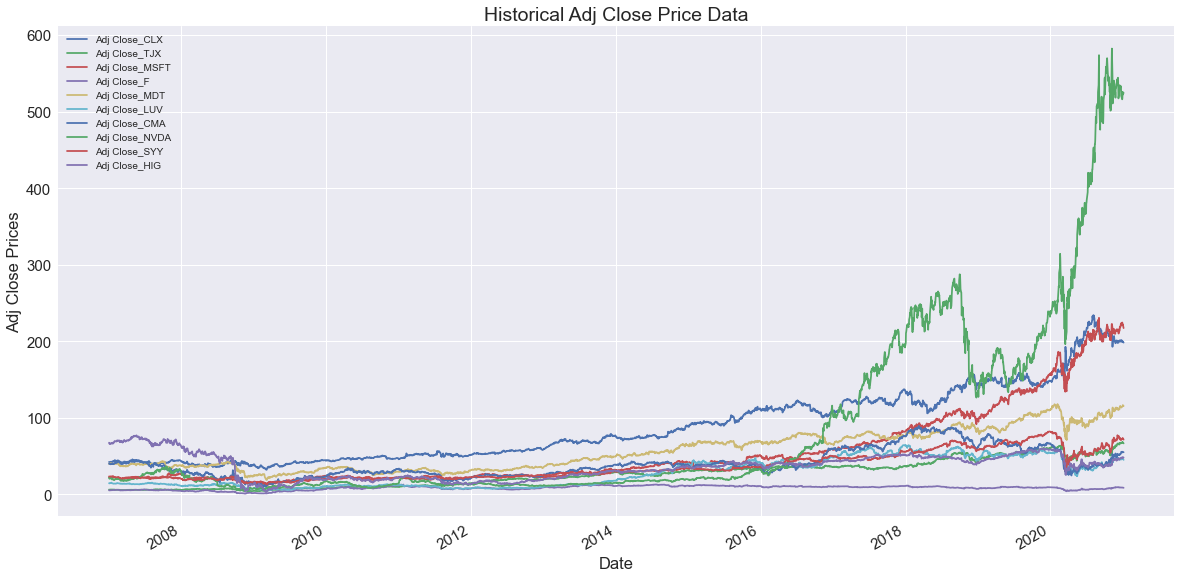

In [5]:
start_date = '2007-01-04'
end_date = '2021-01-05'
my_portfolio = FinancialData(
    tickers = portfolio_tickers,
    cols = ['Adj Close','Volume'],
    start = start_date,
    end = end_date)
my_portfolio.plot_data(figsize=(20,10),fontsize=15);

A key aspect are the returns of each of the assets that compose the portfolio. We can see their distribution and behavior in the graphs below:

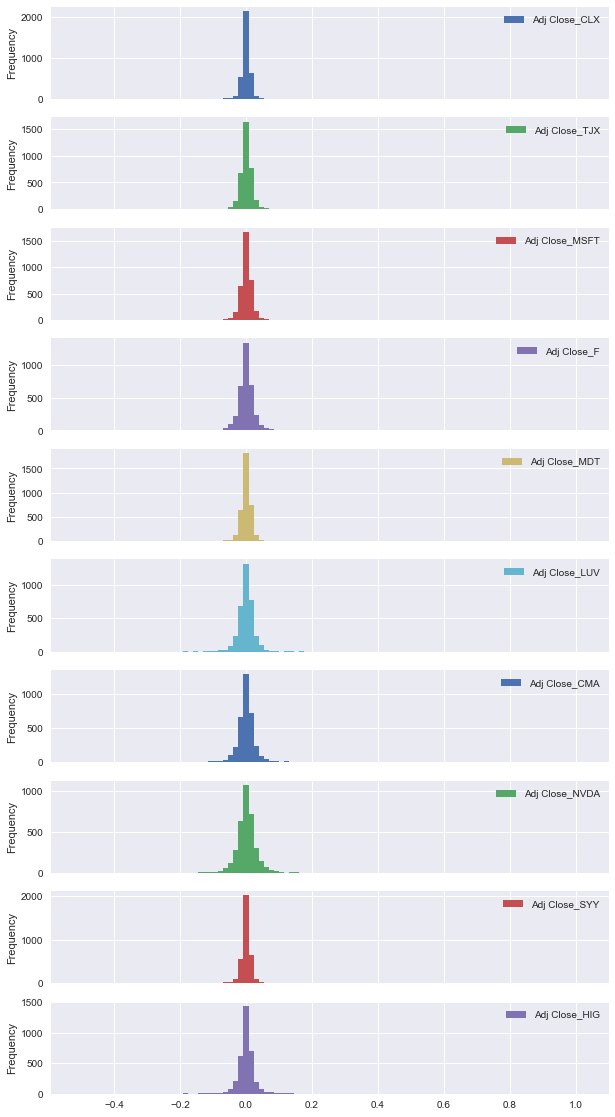

In [6]:
port_returns = my_portfolio.get_returns(plot=True,subplots=True,figsize=(10,20),kind='hist',bins=100)

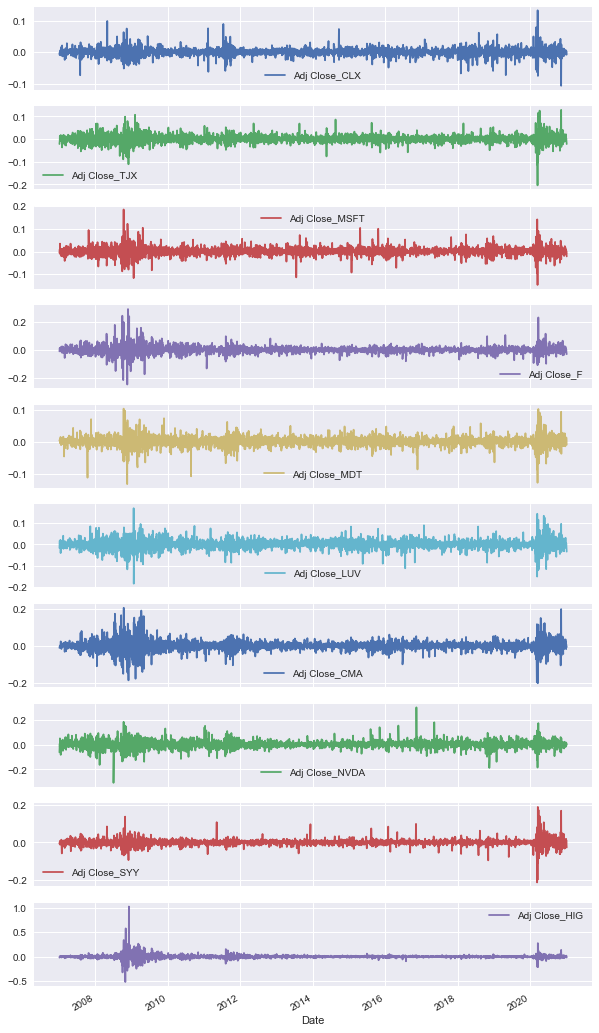

In [7]:
port_returns = my_portfolio.get_returns(plot=True,subplots=True,figsize=(10,20))

The relation between the returns and the market portfolio (in this case I took the SPY ETF, as a proxy for the S&P500 market index), is also very important in the optimization process of portfolios. A visual way to see this relation is by plotting a scatter plot of the returns of each asset vs the returns of the market portfolio, plus the  $\alpha,\beta$ and its corresponding line that resulted from a linear regression:

[*********************100%***********************]  1 of 1 completed


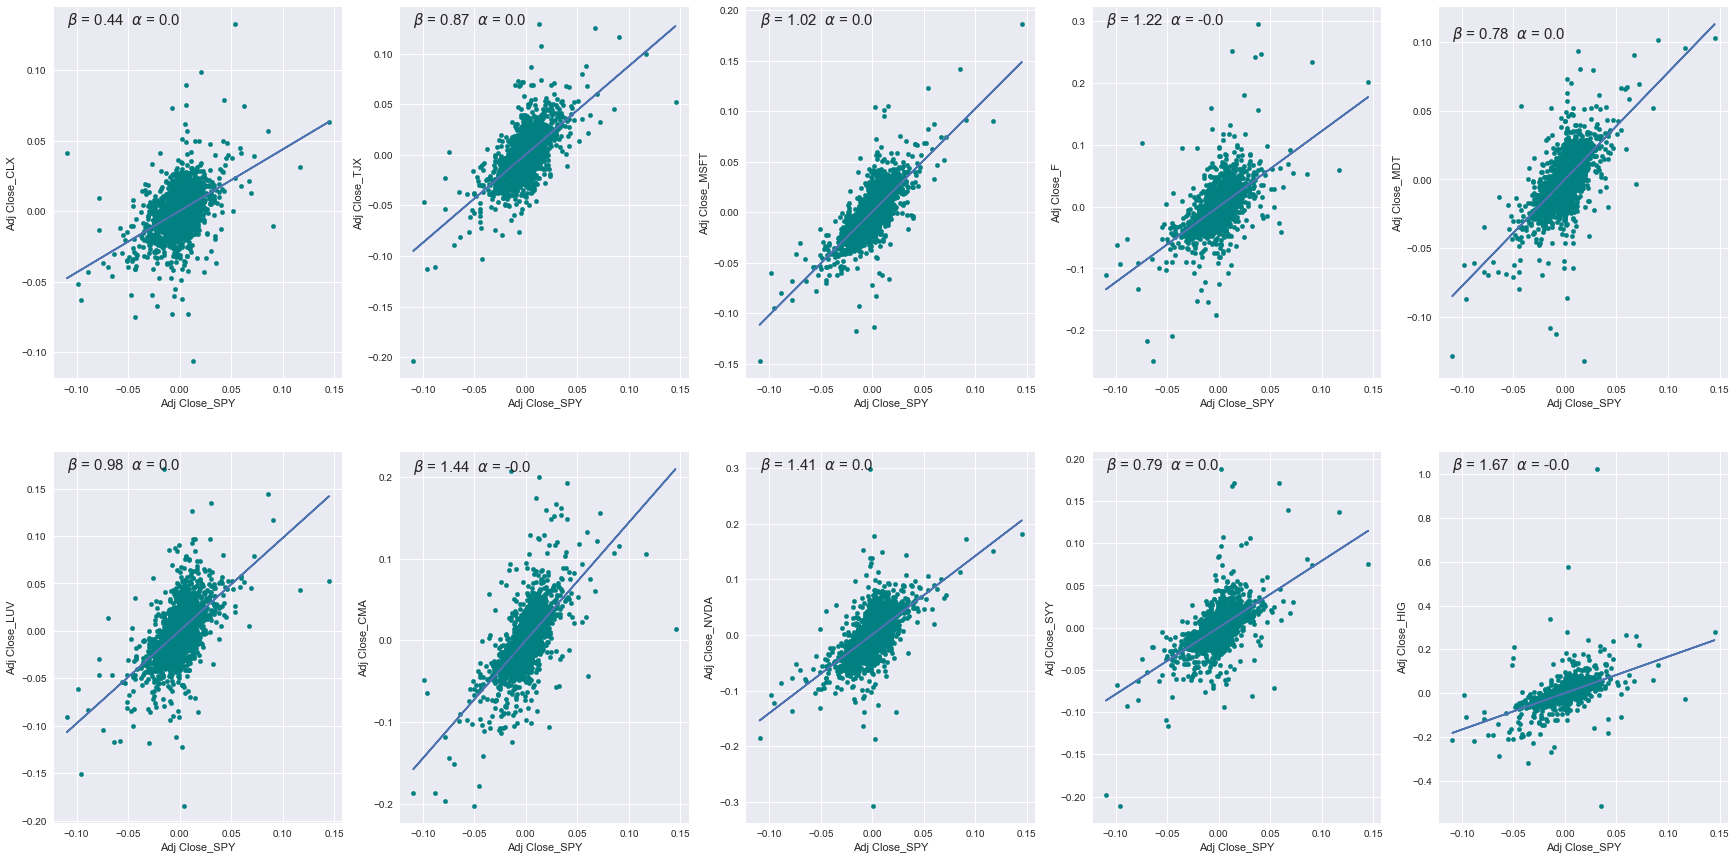

In [8]:
market = yf.download('SPY',start=start_date,end=end_date)['Adj Close'].rename('Adj Close_SPY').pct_change()

portfolio_alphas_betas = my_portfolio.find_beta_alpha(market=market,plot=True,nrows=2,ncols=5,figsize=(30,15),color='teal')

Finally, to have a good representation of the evolution of the adjusted prices for each stock, I normalize the prices with the first value available for analisis. This gives us the representation of the evolution of USD 100 if we invested that amount at the begining of the period. This puts in the same scale the evolution of each asset in the portfolio:

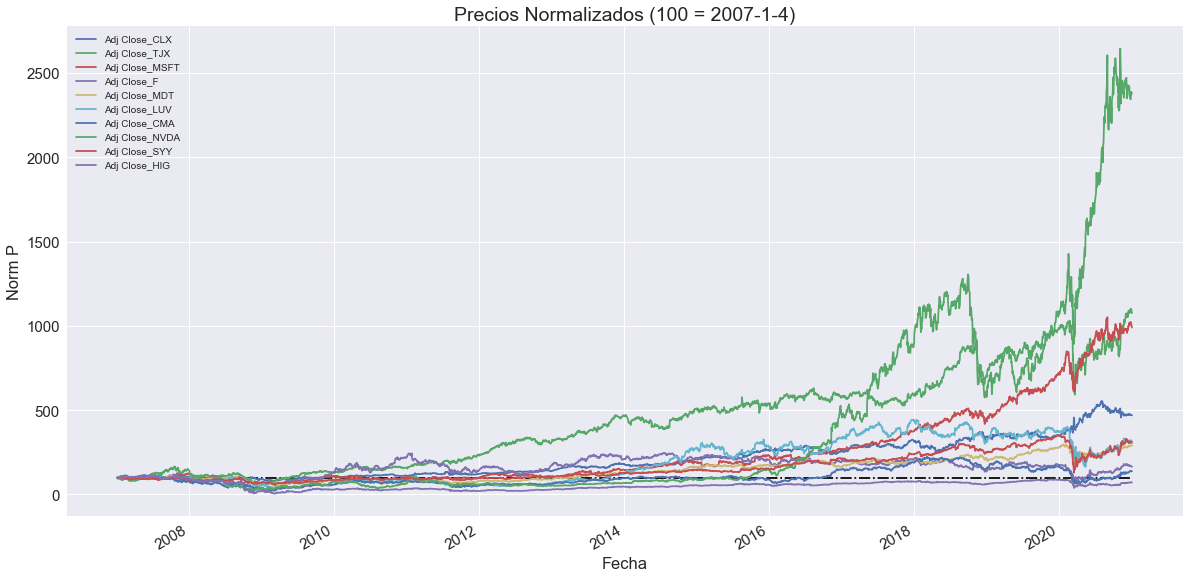

In [9]:
norm_prices =my_portfolio.get_normalized_prices(plot=True,figsize=(20,10),fontsize=15)

Finally, some additional metrics about the returns of the stocks selected for this exercise:

In [10]:
def abs_mean(x):
    """Computes the mean of the absolute values of x
    Inputs:
    -------
    x (pandas DataFrame|Series)
    
    Outputs:
    --------
    ab_m (numerical value): the mean of the absolute values of x
    """
    
    ab = x.abs()
    ab_m = ab.mean()
    return ab_m
    
port_returns.agg(['min','max','mean','std','kurtosis','skew',abs_mean]).transpose()

,min,max,mean,std,kurtosis,skew,abs_mean
Adj Close_CLX,-0.106245,0.132749,0.000518,0.012594,11.221270,0.252592,0.008466
Adj Close_TJX,-0.203995,0.129032,0.000832,0.017753,10.712812,-0.138494,0.012052
Adj Close_MSFT,-0.147390,0.186046,0.000812,0.017955,10.622950,0.344403,0.011966
Adj Close_F,-0.250000,0.295181,0.000511,0.027388,19.210743,0.817162,0.016940
Adj Close_MDT,-0.132344,0.103000,0.000423,0.015484,9.401576,-0.375849,0.010424
Adj Close_LUV,-0.184506,0.170644,0.000578,0.022633,6.500361,-0.149215,0.015559
Adj Close_CMA,-0.202907,0.206897,0.000496,0.028530,9.607306,0.208112,0.018100
Adj Close_NVDA,-0.307265,0.298067,0.001362,0.030337,9.584639,-0.011336,0.020652
Adj Close_SYY,-0.211061,0.187900,0.000469,0.017417,29.086396,0.341663,0.010188
Adj Close_HIG,-0.515609,1.023579,0.000705,0.041073,137.121892,4.661057,0.019199


## 3. Returns Forecast Model
Now that I have the data of prices and returns for the assets that will compose my toy portfolio, the next step is to make a model that forecasts the returns of each of the assets. This forecast will guide the possitions the portfolio should have with respect to each asset, to maximize the Sharpe Ratio. 

To do this, due to the time series nature of the data, I'll use a *recurrent neural network* to forecast the returns of each asset. For this, we need first to define which other variables we'll use as predictive variables of the returns, beyond the past returns of the assets.

Using the [`quandl` API](https://github.com/quandl/quandl-python), which uses multiple data sources to provide a great variety of financial information, I extract other relevant information, which comes in a daily periodicity. I take 6 additional factors, which are:

+ Energy prices, represented by the WTI spot price, taken from the [US Energy Information Administration](https://www.eia.gov).
+ Spread between the 10-year Treasury Constant Maturity and the 2-year Treasury Constant Matiruty, taken from the [Federal Reserve of St. Louis](https://fred.stlouisfed.org)
+ Spread between the 10-year Treasury and the 3-month Treasury, taken from the Fed.
+ Secondary market rate of the 3-month Treasury, which is used also as the risk-free rate, taken from the Fed.
+ The Treasury Inflation-Indexed Long-Term Average Yield, taken from the Fed.
+ TED rate, which is the spread between the 3-month USD LIBOR and the 3-month Bill, taken from the Fed.

Additionally, using the `FinancialData` class I compute the technical factors, with a window of 20 days (an approximation of the number of trading days in a month):

1. *Momentum*: measures how much the prices of assets changed in a time window
$$Momentum_t = \frac{price_t}{price_{t-window}}-1$$

2. *Simple moving average (SMA)*: 
$$SMA_t = \frac{price_t}{\frac{1}{n}\sum_i^nprice_{t-i}}-1$$

3. *Bollinger bands (BB)*:
$$BB_t=\frac{price_t-SMA_t}{2std_t}$$

In [18]:
# Extracting additional factors:
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT',
               'FRED/TEDRATE']
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
add_factors = quandl.get(new_tickers, start_date=start_date, end_date=end_date,
                       api_key=quandl.ApiConfig.api_key)
add_factors.columns = names
add_factors['var_wti'] = add_factors['wti_spot'].pct_change()

# Fill NaN values:
add_factors.fillna(method='ffill',inplace=True)
add_factors.fillna(method='bfill',inplace=True)

# Factors: momentum, simple moving average and bollinger bands:
factors = my_portfolio.rolling_statistics()

Now that we have all the additional factors we want for the model, let's merge all the data into a unique dataframe `total_df`, clean that dataframe and split the data into a train, validation and test subsets. The ordering of the split will follow chornological order, so that our validation and test subsets are at after the train subset. This is to see how well the model performs in more recent data. 

In [19]:
# Merge dataframes to get the full data for modeling:
total_df = port_returns.merge(factors,right_index=True,left_index=True,how='left')
total_df = total_df.merge(add_factors,right_index=True,left_index=True,how='left')

# Drop NaN that result from rolling functions:
total_df.dropna(subset=factors.columns,inplace=True)

# Define the label columns:
label_cols = total_df.columns[:n_stocks]

# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = total_df.shape[1]
total_size = len(total_df)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = total_df.iloc[:train_size,:]
val_df = total_df.iloc[train_size-window_size:train_size+val_size,:]
test_df = total_df.iloc[train_size+val_size-window_size:,:]

Now that I have all the information needed for this exercise, I use the `WindowGenerator` object that can be found in the auxiliary module `financial_data`. This object transforms the time series data into `tensorflow.data.Dataset` objects with the addecuate shape for the models. whose dimensions are:

$$\text{batch size}\times \text{time window}\times \text{# predictive variables} \tag{input data}$$
$$\text{batch size}\times \text{forecasting window}\times \text{# target variables} \tag{target data}$$


Because the portfolio is formed by 10 stocks we expect to see 10 returns to be forcasted, as can be seen in the last dimension of the target shape. Another important thing to notice is that, to avoid sequence bias, inside the `WindowGenerator` object there is a `shuffle=True` attribute, which shuffles the data:

In [20]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Train input shape: (512, 5, 47)
Train target shape: (512, 1, 10)
Validation input shape: (512, 5, 47)
Validation target shape: (512, 1, 10)
Test input shape: (351, 5, 47)
Test target shape: (351, 1, 10)


The next step is to create the model. For this I'll use the [TensorFlow python API](https://www.tensorflow.org/api_docs/python/tf) to create the *Recurrent Neural Networks'* architecture. 

In [21]:
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# # Model architecture creation:
# model_1 = Sequential([
#     BatchNormalization(
#         input_shape = (window_size,num_features),
#         name = 'Batch_Norm_1'),
#     LSTM(512,return_sequences=True,name='LSTM_1'),
# #    BatchNormalization(),
#     LSTM(512,name='LSTM_2'),
# #    BatchNormalization(momentum=0.8),
#     Dense(256,activation='relu',name='Dense_1'),
#     Dense(n_stocks,name='Returns')
# ])

# Learning Rate Schedule: used to decide the learning rate:
# # lr_schedule = tf.keras.callbacks.LearningRateScheduler(
# #                 lambda epoch: 1e-8*10**(epoch/20))

# Checkpoint callback to save the model:
# checkpont_rnn = ModelCheckpoint(
#     filepath='model_1_rnn',
#     save_weights_only=False,
#     save_freq = 'epoch',
#     monitor = 'val_loss',
#     save_best_only = True,
#     verbose = 0)

# # Define optimizer
# optimizer = tf.keras.optimizers.Adam(lr=1e-3)

# # Compile Model
# model_1.compile(
#     loss=tf.keras.losses.Huber(),
#     metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
#     optimizer=optimizer)

# # Train model
# history = model_1.fit(
#     my_window.train,
#     validation_data=my_window.val,
#     epochs=100)
# model_1.summary()

Because of the computation required for the training of a neural net, I used [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb?hl=es), in particular the GPU hardware accelerator capability. Thus, I trained and saved the model above, and loaded here to continue with the exercise

![](i/21.png)

To decide which learning rate to use, I used a learning rate schedule to see which produced a smooth and fast minimization of the loss function. The results of this exercise can be seen below:
![](i/29.png)

I chose a learning rate of 0.001 as a result.

In [22]:
model_1 = load_model('rnn_model_1')

Below you can see the architecture I used for this model, that starts with a 1-dimension convolutional layer, followed by two recurrent layers with *Long Short Term Memory* cells, a normalization layer and ends with two dense layers, one with the a [ReLU (*Rectified Linear Unit*)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) and the output layer, which returns the 10 prediction of returns.

In [23]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Batch_Norm_1 (BatchNormaliza (None, 5, 47)             188       
_________________________________________________________________
LSTM_1 (LSTM)                (None, 5, 512)            1146880   
_________________________________________________________________
LSTM_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
Returns (Dense)              (None, 10)                2570      
Total params: 3,380,166
Trainable params: 3,380,072
Non-trainable params: 94
_________________________________________________________________


In the graphs below you can see the training loss (in this case I used the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers). I used also the common metric *Root Mean Squared Errors (RMSE)*, which is in the right plot. 

![](i/31.png)

In [24]:
# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Training','Validation'])
# plt.title('Huber Loss: Training and Validation')
# plt.subplot(1,2,2)
# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Training','Validation'])
# plt.title('RMSE Loss: Training and Validation')

Finally, I evaluate the model for the lattest data, which is in the test set:

In [25]:
model_1.evaluate(my_window.test)

1/1 [==============================] - 2s 2s/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - mae: 0.0204


[0.0010197722585871816, 0.031933870166540146, 0.02037873864173889]

Now that I have the model let's see it's results compared with the real returns for each dataset (train, val, test):

### **_Training Results_**

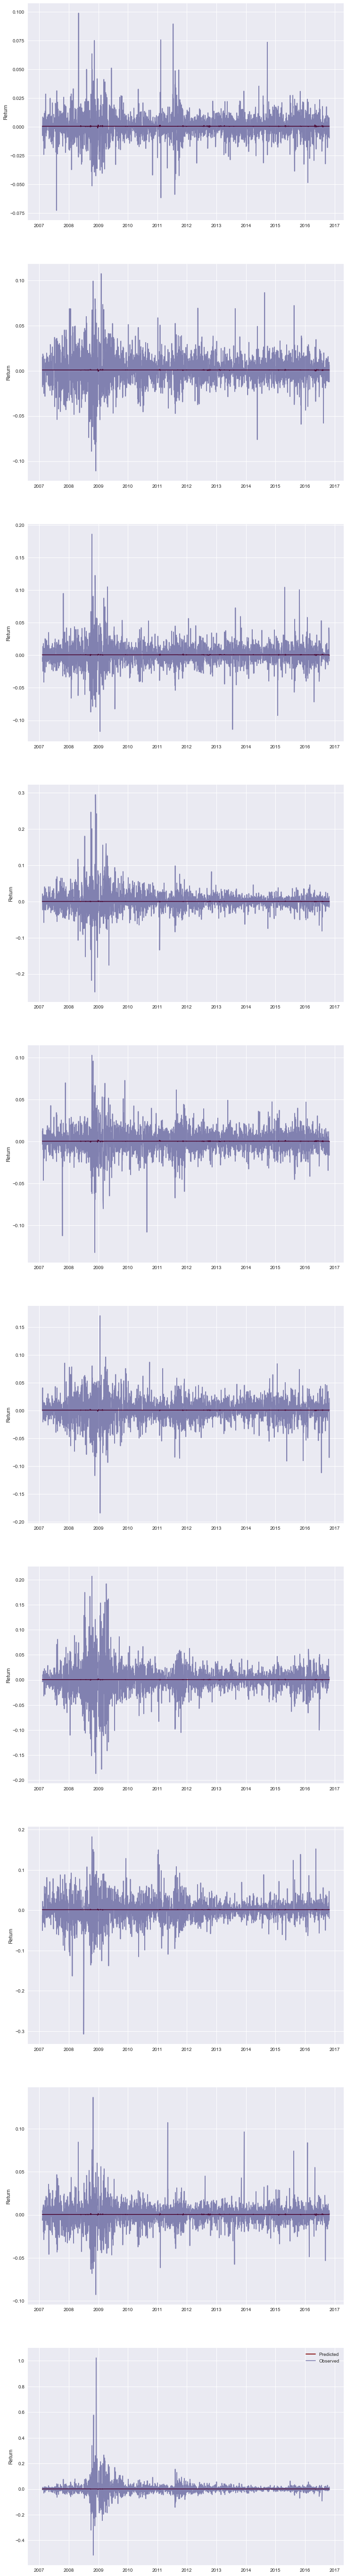

In [26]:
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(my_window_2.train,train_df,window_size,model_1)

### **_Validation Results_**

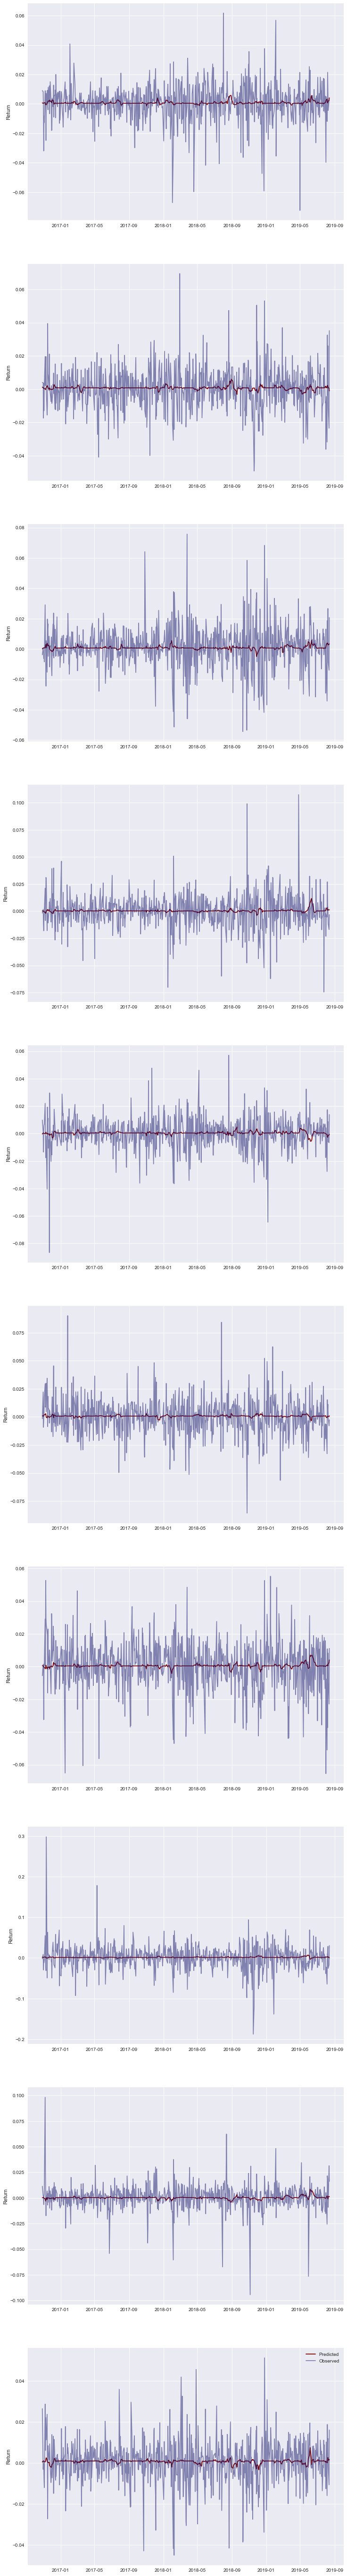

In [27]:
plot_window(my_window_2.val,val_df,window_size,model_1)

### **_Test Results_**

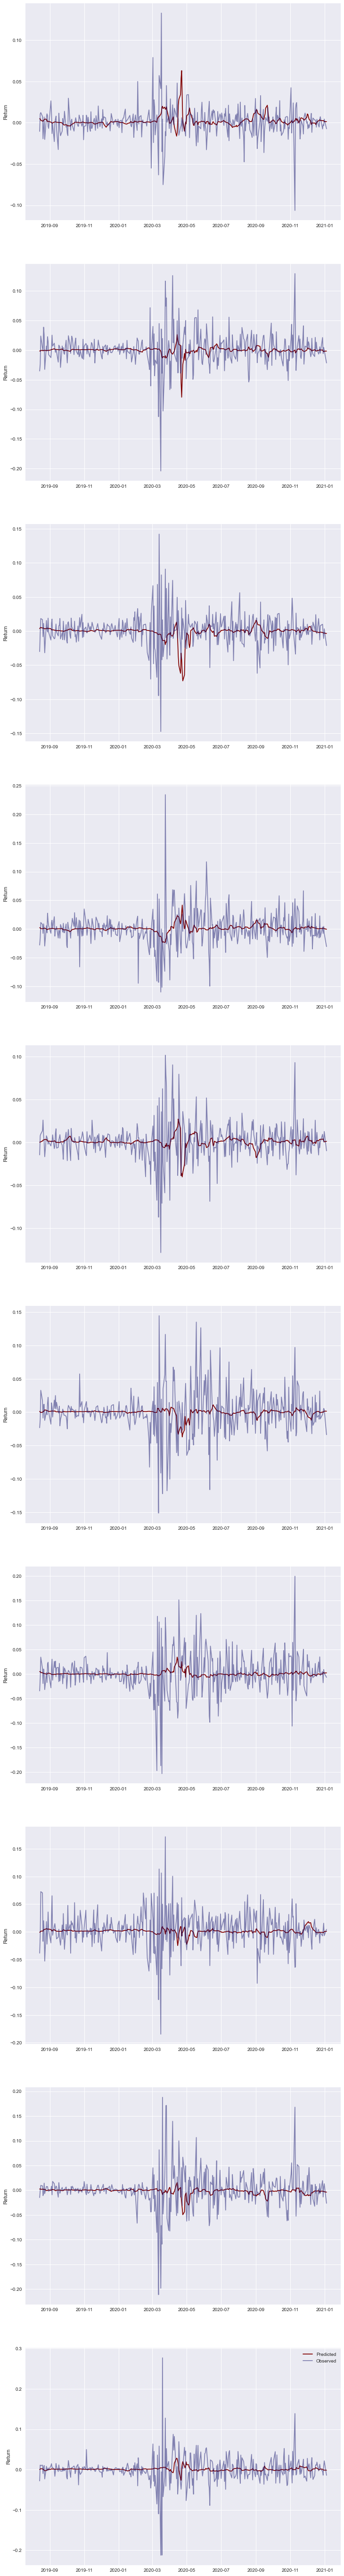

In [28]:
plot_window(my_window_2.test,test_df,window_size,model_1)

## 4. Portfolio Optimization
Now that we have a way returns forecast model, we could use the forecasted returns to take possitions on the different assets that compose our portfolio, by allocating weights to the assets such that the Sharpe Ratio is maximized:

$$\text{Sharpe Ratio} = \frac{R_p-R_f}{\sigma_p}$$

where $R_p$ is the return of the portfolio, $R_f$ is the risk-free rate (I used the 3-month Treasury bill daily rate as the risk-free rate).

In [33]:
columns = ['FR_'+ticker for ticker in portfolio_tickers]
y_train = model_1.predict(my_window_2.train)
y_val = model_1.predict(my_window_2.val)
y_test = model_1.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=total_df.index[5:],columns=columns)
rfr = add_factors['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')
# ret_hat_df.rolling(40).agg(lambda x: optimize_portfolio(
#     returns = ret_hat_df[ret_hat_df.columns[:-1]],
#     rfr = ret_hat_df[ret_hat_df.columns[-1]]))
opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
opt_weights.shape

(3501, 10)

In [36]:
opt_weights.shape

(3501, 10)

In the variable `opt_weights` the optimal weights, given the predicted returns and the minimization function of the -Sharpe Ratio, are stored. This continual change assumes the investor is willing to reallocate daily the assets in the portfolio. This gives a demostration of how you could manage your portfolio by using Deep Learning to forecast returns, and based on those forecasts, manage your portfolio. Because of the demostration nature of this exercise, many available assets where leaved out, but with more computational power many more could be plugged in and analyzed and used in the management of the portfolio. 

Finally, as can be seen in the results, the forecasting of the returns is not an easy endevor, due to the stocastic nature of them, resulting in difficult to predict jumps and falls. However, all of the work presented could be automated and improved, using NLP to measure the market's sentiment taking advantage of the live news feed (or Twitter information). You could also add image recognition, to exploit satellite data, or enhance the algorithm adding Reinforcement Learning.